In [1]:
import pandas as pd
df = pd.read_feather('data_future/BTCUSDT_FUTURE_2020-01-01@2024-01-01@15m.feather')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136873 entries, 0 to 136872
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   open_time               136873 non-null  int64  
 1   open                    136873 non-null  float64
 2   high                    136873 non-null  float64
 3   low                     136873 non-null  float64
 4   close                   136873 non-null  float64
 5   volume                  136873 non-null  float64
 6   close_time              136873 non-null  int64  
 7   quote_volume            136873 non-null  float64
 8   count                   136873 non-null  int32  
 9   taker_buy_volume        136873 non-null  float64
 10  taker_buy_quote_volume  136873 non-null  float64
 11  ignore                  136873 non-null  bool   
dtypes: bool(1), float64(8), int32(1), int64(2)
memory usage: 11.1 MB


In [2]:
price = df['close']
price = price.to_numpy()
price = price[81550:81650]
len(price)

100

In [3]:
from matplotlib import pyplot as plt
import numba
import numpy as np

@numba.njit
def smooth_price(price, length=2, iterations_left=1):
    if iterations_left <= 0:
        return price

    new_price = np.zeros_like(price)
    new_price[:] = price[:]

    for p in range(length, price.shape[0]-length):
        window = price[p-length:p+length+1]
        only_up = np.mean(window[1:] >= window[:-1])

        if only_up != 0 and only_up != 1:
            new_price[p] = (new_price[p-1] + new_price[p+1]) / 2

    return smooth_price(new_price, length+1, iterations_left-1)

def get_extrema(smoothed, price, length=2, extrema_length=3):
    maxima = []
    maxima_x = []
    minima = []
    minima_x = []
    for p in range(max(length, extrema_length), smoothed.shape[0]-max(length, extrema_length)):
        window_before = smoothed[p-length:p+1]
        window_after = smoothed[p:p+length+1]
        only_up = np.mean(window_before[1:] >= window_before[:-1])
        only_down = np.mean(window_after[1:] <= window_after[:-1])
        if only_up == 1 and only_down == 1:
            arg_max = np.argmax(price[p-extrema_length:p+1+extrema_length])
            max_i = p-extrema_length+arg_max
            maxima.append(price[max_i])
            maxima_x.append(max_i)
        if only_up == 0 and only_down == 0:
            arg_min = np.argmin(price[p-extrema_length:p+1+extrema_length])
            min_i = p-extrema_length+arg_min
            minima.append(price[min_i])
            minima_x.append(min_i)
    return minima, minima_x, maxima, maxima_x

smoothed = smooth_price(price, 2, 30)

# get_extrema will be discussed in a minute
minima, minima_x, maxima, maxima_x = get_extrema(smoothed, price, 2, 10)

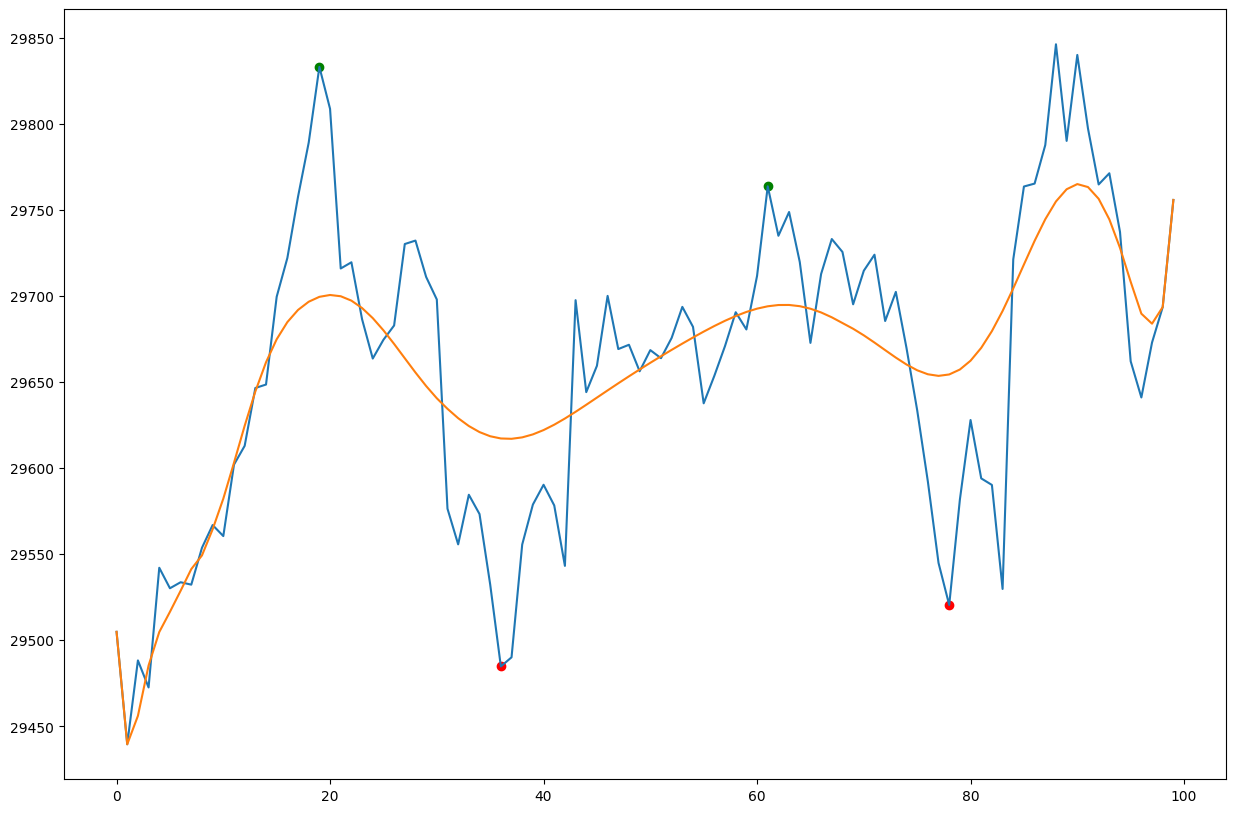

In [4]:
import plotly.express as px
import pandas as pd

#df = pd.DataFrame(dict(price=price, smoothed=smoothed))

# fig = px.line(df, x="year", y="lifeExp", color='country')
# fig.show()

plt.figure(figsize=(15,10))
plt.plot(price, label="price")
plt.plot(smoothed, label="smoothed")
plt.scatter(maxima_x, maxima, c="g")
plt.scatter(minima_x, minima, c="r")

In [5]:
df_a = df.iloc[81550:81650,:]
df_a.reset_index(inplace=True, drop=True)
df_a

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1654276500000,29485.1,29524.1,29442.5,29504.9,2282.719,1654277399999,6.730861e+07,27991,1114.506,3.286587e+07,False
1,1654277400000,29504.9,29557.6,29421.1,29439.6,4055.196,1654278299999,1.196139e+08,31858,1894.681,5.589725e+07,False
2,1654278300000,29439.5,29512.3,29418.6,29488.3,2390.784,1654279199999,7.046993e+07,24070,1366.456,4.027603e+07,False
3,1654279200000,29488.2,29517.2,29454.9,29472.6,1855.329,1654280099999,5.470375e+07,20797,961.911,2.836325e+07,False
4,1654280100000,29472.5,29544.4,29450.0,29542.1,1729.057,1654280999999,5.102683e+07,21079,986.518,2.911391e+07,False
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1654362000000,29737.0,29742.9,29650.0,29662.0,4030.075,1654362899999,1.196684e+08,33619,1702.864,5.056481e+07,False
96,1654362900000,29661.9,29666.6,29592.4,29641.0,3361.019,1654363799999,9.959650e+07,30732,1556.705,4.613552e+07,False
97,1654363800000,29641.0,29714.0,29592.4,29672.9,2423.873,1654364699999,7.189557e+07,24422,1429.354,4.240276e+07,False
98,1654364700000,29673.0,29729.6,29671.7,29693.5,1705.936,1654365599999,5.067050e+07,18526,975.684,2.898059e+07,False


In [7]:
from get_df_pivot_point import get_pivot_point

df_t = get_pivot_point(df_a)
df_t.head(30)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,pivot_point
0,1654276500000,29485.1,29524.1,29442.5,29504.9,2282.719,1654277399999,6.730861e+07,27991,1114.506,3.286587e+07,False,0
1,1654277400000,29504.9,29557.6,29421.1,29439.6,4055.196,1654278299999,1.196139e+08,31858,1894.681,5.589725e+07,False,0
2,1654278300000,29439.5,29512.3,29418.6,29488.3,2390.784,1654279199999,7.046993e+07,24070,1366.456,4.027603e+07,False,0
3,1654279200000,29488.2,29517.2,29454.9,29472.6,1855.329,1654280099999,5.470375e+07,20797,961.911,2.836325e+07,False,0
4,1654280100000,29472.5,29544.4,29450.0,29542.1,1729.057,1654280999999,5.102683e+07,21079,986.518,2.911391e+07,False,0
5,1654281000000,29542.1,29546.0,29494.1,29530.2,1385.449,1654281899999,4.090349e+07,18288,569.074,1.680188e+07,False,0
6,1654281900000,29530.3,29540.0,29487.9,29533.7,1190.611,1654282799999,3.513970e+07,14770,533.722,1.575216e+07,False,0
7,1654282800000,29533.6,29599.9,29510.0,29532.3,2319.176,1654283699999,6.854390e+07,23932,1121.428,3.314348e+07,False,0
8,1654283700000,29532.2,29553.7,29476.1,29553.7,1818.147,1654284599999,5.365168e+07,18525,924.976,2.729404e+07,False,0
9,1654284600000,29553.7,29574.9,29493.0,29566.9,1842.971,1654285499999,5.444198e+07,20269,843.250,2.491088e+07,False,0
